In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Monté-Carlo simulation of the assets prices $(S_{t})_{0 \leq t \leq T}$



In [ ]:
def monte_carlo_price_simulator(L, m, S0, r, sigma):
    Price_simulation = np.zeros((L, m))
    dt = 1 / (L - 1)  # Time increment assuming total time span T=1
    for path in range(m):
        Price_simulation[0, path] = S0
        for i in range(1, L):
            z_i = np.random.normal(0, 1)
            Price_simulation[i, path] = Price_simulation[i - 1, path] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z_i)
    return Price_simulation

L = 10  # number of periods
m = 100  # number of paths simulated
S0 = 1  # initial asset price
r = 0  # risk-free rate
sigma = 0.02  # volatility

sim_asset_prices = monte_carlo_price_simulator(L, m, S0, r, sigma)


Visualisation of asset prices generated :

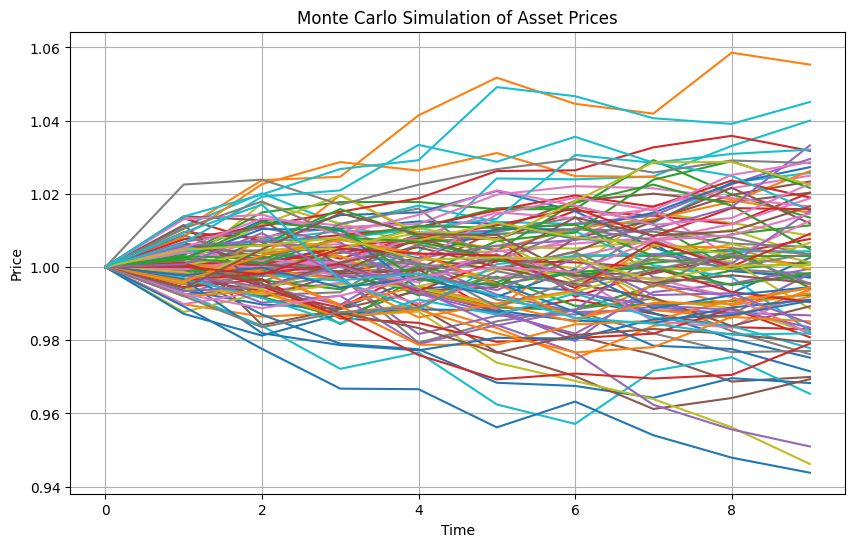

In [ ]:
def visualisation_price(L,m,S0,sim_asset_prices):
    plt.figure(figsize=(10, 6))
    for i in range(m):
        price = sim_asset_prices[:, i]
        plt.plot(range(L), price, label=f"Path {i+1}")

    plt.title('Monte Carlo Simulation of Asset Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

visualisation_price(L,m,S0,sim_asset_prices)

# Computation of the quantisized assets prices  $(\hat{S_{t}})_{0 \leq t \leq T}$

Let's define the discretizing function of the asset prices:

In [ ]:
def quant_function(x,M,n):
  if abs(x)>M:
    return 0
  k=int(x*n/M)
  return k*M/n

Now we need to choose $\epsilon$, M and n such that : $\frac{M}{n}<\frac{\epsilon}{2}$ and $\frac{max_t \mathbf{E}[S_{t}^{2}]}{M}<\frac{\epsilon}{2}$

In [ ]:
second_order_moments = np.array([np.mean(sim_asset_prices[k,:]**2) for k in range(L)])
eps =0.1
M= 4*np.max(second_order_moments)/eps
n= int(4*M/eps)

print(eps)
print(n)
quant_sim_asset_prices = np.array([[quant_function(sim_asset_prices[t,k],M,n) for k in range(m)] for t in range(L)])

0.1
1605


Visualisation of the quantisized asset prices :

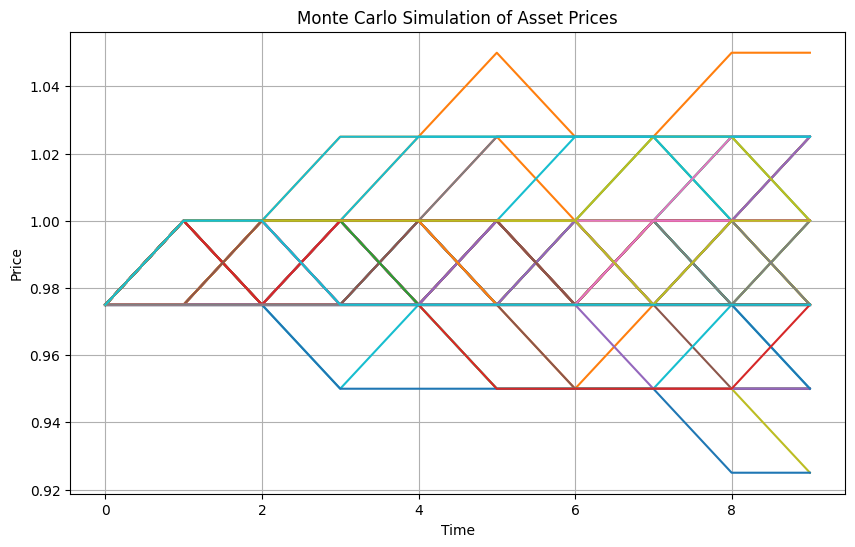

In [ ]:
visualisation_price(L,m,S0,quant_sim_asset_prices)

# Computation of the corresponding price of the American option of payoff H using dynamic programming

Let's compute the corresponding prices $(\hat{V_{t}})_{0 \leq t \leq T}$ of the American option of payoff H using this formula :     

\begin{cases}
  \hat{V_{T}} = h(T,\hat{S_{T}}) \\
  \hat{V_{t}} = max(h(t,\hat{S_{t}}),\mathbf{E}[\hat{V}_{t+1}|\hat{S_{t}} ])
\end{cases}

Knowing that :    
\begin{cases}
\mathbf{E}[\hat{V}_{t+1}|\hat{S_{t}}=x_{i}^{t}]= \frac{\Sigma_{j=1}^{n} \hat{V}_{t+1}(t+1,x_{j}^{t+1}) \mathbf{P}(\hat{S_{t}}=x_{i}^{t},\hat{S}_{t+1}=x_{j}^{t+1})}{\Sigma_{j=1}^{n} \mathbf{P}(\hat{S_{t}}=x_{i}^{t},\hat{S}_{t+1}=x_{j}^{t+1})}, \forall i \leq n \\
\mathbf{P}(\hat{S_{t}}=x_{i}^{t},\hat{S}_{t+1}=x_{j}^{t+1})=\mathbf{P}(S_{t}\in[x_{i}^{t},x_{i+1}^{t}),S_{t+1}\in [x_{j}^{t+1},x_{j+1}^{t+1})) = \frac{1}{m} \Sigma_{k=1}^{m} \mathbf{1}_{ \{x_{i}^{t} \leq S_{t}^{(k)} <x_{i}^{t+1},x_{j}^{t+1} \leq S_{t+1}^{(k)} <x_{j+1}^{t+1} \}}
\end{cases}

In [ ]:
def prob_x_it_x_jt1(t,xit,xi1t,xjt1,xj1t1,sim_asset_prices):
  prob=0
  for l in range(m):
    if xit<=sim_asset_prices[t,l]<xi1t and xjt1<=sim_asset_prices[t+1,l]<xj1t1:
      prob+=1
  prob/=m
  return prob

def payoff_function(x,K):
  return np.maximum(x-K,0)

In [ ]:
def dynamic_prog(K,sim_asset_prices,quant_sim_asset_prices):
  V_hat=np.zeros((L,n))
  V_hat[L-1,:] = payoff_function(np.linspace(-M,M,n),K)
  for t in range(L-2,-1,-1):
    print("this is t="+str(t))
    for j in range(n):
      cond_exp=0
      prob=0
      for i in range(n):
        p=prob_x_it_x_jt1(t,j*M/n,(j+1)*M/n,i*M/n,(i+1)*M/n,sim_asset_prices)
        cond_exp+= V_hat[t+1,i]*p
        prob+= p
      cond_exp/=prob
      V_hat[t,j] = max([payoff_function(j*M/n,K), cond_exp])
  return V_hat

def option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices):
  k= int(S0*n/M)
  V_hat=dynamic_prog(K,sim_asset_prices,quant_sim_asset_prices)
  return V_hat[0,k]
K=0.95
price=option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices)
print("the price for K="+str(K)+" is "+str(price))

this is t=8


<ipython-input-9-1ed54ee00412>:13: RuntimeWarning: invalid value encountered in scalar divide
  cond_exp/=prob


this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
the price for K=0.95 is 0.04637367001154573


##Let's plot the price of the option for different values of the strike K

this is t=8


<ipython-input-8-1ed54ee00412>:13: RuntimeWarning: invalid value encountered in scalar divide
  cond_exp/=prob


this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this

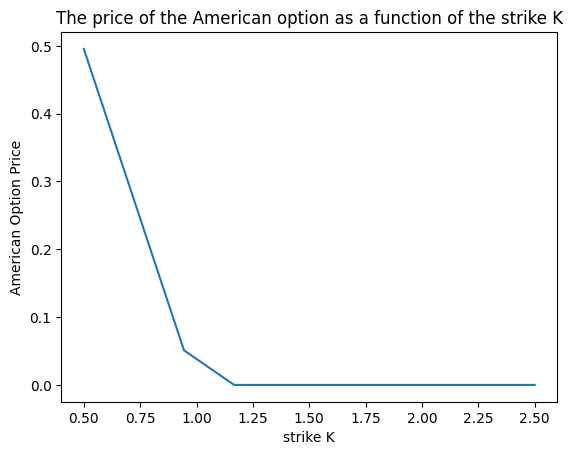

In [ ]:
X=np.linspace(0.5,2.5,10)
Y=[option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices) for K in X]
plt.plot(X,Y)
plt.title('The price of the American option as a function of the strike K')
plt.xlabel('strike K')
plt.ylabel('American Option Price')
#plt.grid(True)
plt.show()

In [ ]:
maturity=np.arange(5,16)
prices=np.zeros(np.shape((maturity)))
for T in maturity:
  L=T
  sim_asset_prices = monte_carlo_price_simulator(T, m, S0, r, sigma)
  quant_sim_asset_prices = np.array([[quant_function(sim_asset_prices[t,k],M,n) for k in range(m)] for t in range(T)])
  K=0.95
  prices[T-5]= option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices)


this is t=3


<ipython-input-8-1ed54ee00412>:13: RuntimeWarning: invalid value encountered in scalar divide
  cond_exp/=prob


this is t=2
this is t=1
this is t=0
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=9
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=10
this is t=9
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=11
this is t=10
this is t=9
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
this is t=12
this is t=11
this is t=10
this is t=9
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=

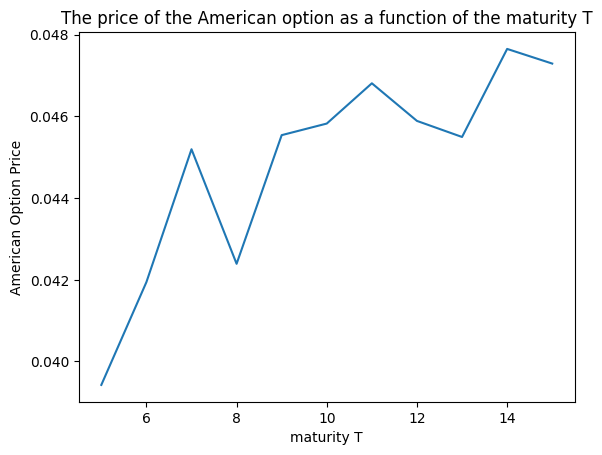

In [ ]:
plt.plot(maturity,prices)
plt.title('The price of the American option as a function of the maturity T')
plt.xlabel('maturity T')
plt.ylabel('American Option Price')
#plt.grid(True)
plt.show()

In [ ]:
L=10
m=500
sim_asset_prices = monte_carlo_price_simulator(L, m, S0, r, sigma)
quant_sim_asset_prices = np.array([[quant_function(sim_asset_prices[t,k],M,n) for k in range(m)] for t in range(L)])
K=0.95
print("for m=1000"+str(option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices)))
m=1000
sim_asset_prices = monte_carlo_price_simulator(L, m, S0, r, sigma)
quant_sim_asset_prices = np.array([[quant_function(sim_asset_prices[t,k],M,n) for k in range(m)] for t in range(L)])
K=0.95
print("for m=1000 "+str(option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices)))

this is t=8


<ipython-input-8-1ed54ee00412>:13: RuntimeWarning: invalid value encountered in scalar divide
  cond_exp/=prob


this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
for m=10000.04564726217937615
this is t=8
this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0


In [ ]:
m=1000
sim_asset_prices = monte_carlo_price_simulator(L, m, S0, r, sigma)
quant_sim_asset_prices = np.array([[quant_function(sim_asset_prices[t,k],M,n) for k in range(m)] for t in range(L)])
K=0.95
print("for m=1000"+str(option_price_0(S0,K,sim_asset_prices,quant_sim_asset_prices)))

this is t=8


<ipython-input-9-1ed54ee00412>:13: RuntimeWarning: invalid value encountered in scalar divide
  cond_exp/=prob


this is t=7
this is t=6
this is t=5
this is t=4
this is t=3
this is t=2
this is t=1
this is t=0
for m=10000.04470255676142361
